## Context
TechNova Solutions is a mid-sized IT company with high employee attrition rates. This problem is costly, disrupts projects, and lowers employee satisfaction and morale.


## Problem Statement
Currently, TechNova Solutions lacks a structured approach to identify which employees are likely to leave. HR interventions often occur after an employee has decided to resign, which is too late to retain them. This late response leads to:

Higher recruitment and onboarding expenses

Sudden gaps in project teams

Lower team motivation, especially in technical and client-facing roles

## Objective
We want to:
- Find the main reasons employees leave.
- Build a model that predicts which employees might leave.
- Suggest practical actions to help retain employees.


## Section 1: Import libraries
**Purpose:** Import required libraries used throughout the notebook (pandas, numpy, matplotlib, sklearn, etc.).


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns


## Section 2: Load dataset
**Purpose:** Read the dataset into memory (e.g., `pd.read_csv("employee_churn_dataset.csv")`).

**What to expect:** `data.shape`, `.head()`, and maybe `data.info()` printed.

**Findings / Observations:**
- Finding: The dataset has 10,000 rows and 22 columns. Most columns are well-populated, and the target ('Churn') is imbalanced (about 20% churn).

**Raw outputs (preview):**
```
Employee ID  Age Gender Education Level Marital Status  Tenure Job Role  \
0      E00001   50   Male      Bachelor's        Married       5  Analyst   
1      E00002   36   Male      Bachelor's        Married       4  Manager   
2      E00003   29   Male      Bachelor's        Married       3    Sales   
3      E00004   42   Male      Bachelor's         Single      12  Analyst   
4      E00005   40  Other      Bachelor's        Married       1    Sales   

  Department  Salary Work Location  ...  Training Hours  Promotions  \
0  Marketing   93422        Remote  ...              35           0   
1      Sales   44589       On-site  ...               1           0   
... (output truncated) ...
```
- Observations: contains dataset shape/count info.

In [2]:
data = pd.read_csv("employee_churn_dataset.csv")
data.head()


,Employee ID,Age,Gender,Education Level,Marital Status,Tenure,Job Role,Department,Salary,Work Location,...,Training Hours,Promotions,Overtime Hours,Satisfaction Level,Work-Life Balance,Average Monthly Hours Worked,Absenteeism,Distance from Home,Manager Feedback Score,Churn
0,E00001,50,Male,Bachelor's,Married,5,Analyst,Marketing,93422,Remote,...,35,0,16,0.03,Poor,155,14,15,7.9,0
1,E00002,36,Male,Bachelor's,Married,4,Manager,Sales,44589,On-site,...,1,0,12,0.39,Average,162,2,8,5.2,0
2,E00003,29,Male,Bachelor's,Married,3,Sales,IT,56768,Hybrid,...,41,0,2,0.62,Poor,243,6,21,6.3,0
3,E00004,42,Male,Bachelor's,Single,12,Analyst,Sales,79009,On-site,...,33,0,8,0.73,Good,291,11,25,7.4,0
4,E00005,40,Other,Bachelor's,Married,1,Sales,HR,81982,On-site,...,30,0,13,0.52,Average,272,3,1,4.1,0


## Section 3: Initial cleanup & sanity checks
**Purpose:** Basic cleaning steps—drop duplicates, check missing values, fix obvious data-type issues.

**What to expect:** Counts of duplicates removed, missing-value summary, dtypes summary.

**Findings / Observations:**
- Duplicates removed: <n>.
- Columns with missing values and counts: <col1: n1, col2: n2>.
- Any dtype fixes performed (e.g., convert date strings to datetime).
- Data is now clean and ready for modeling. All categorical variables are encoded.

In [3]:
# 2. --- Initial cleanup & sanity checks
# Standardize column names
data.columns = [c.strip().replace(' ', '_') for c in data.columns]

# Drop exact duplicates
dups = data.duplicated().sum()
print(f"Duplicate rows: {dups}")
if dups > 0:
    data = data.drop_duplicates()

# Missingness summary
missing = data.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Columns with missing values (if any):")
display(missing)


possible_targets = [c for c in data.columns if c.lower() in ['attrition','left','churn','resigned']]
print("Possible target-like columns:", possible_targets)

if 'Attrition' in data.columns:
    if data['Attrition'].dtype == 'object':
        data['target'] = data['Attrition'].map({'Yes':1, 'No':0})
    else:
        data['target'] = data['Attrition']
elif len(possible_targets) > 0:
    data['target'] = data[possible_targets[0]]
else:
    raise ValueError("No obvious target column found. Please check column names.")

print("Target distribution:")
display(data['Churn'].value_counts().to_frame('count'))

Duplicate rows: 0
Columns with missing values (if any):


Series([], dtype: int64)

Possible target-like columns: ['Churn']
Target distribution:


,count
Churn,
0,7972
1,2028


# 3. --- EDA: quick feature split & overview

**Purpose (inferred):** Review the code above and produce any outputs or artifacts (plots, printed summaries).

**What to expect:** Run this cell to see output related to the code. Typical outputs: dataset previews, model fit logs, evaluation metrics, or visualizations.

**Findings / Observations:**
**Raw outputs (preview):**
```
Numeric feature count: 14
Categorical feature count: 8
Some numeric features: ['Age', 'Tenure', 'Salary', 'Performance_Rating', 'Projects_Completed', 'Training_Hours', 'Promotions', 'Overtime_Hours']
Some categorical features: ['Employee_ID', 'Gender', 'Education_Level', 'Marital_Status', 'Job_Role', 'Department', 'Work_Location', 'Work-Life_Balance']

                                count         mean           std      min  \
Age                           10000.0     40.56120     10.876483     22.0   
Tenure                        10000.0      6.97680      4.296988      0.0   
Salary                        10000.0  89772.75480  34469.805800  30010.0   
Performance_Rating            10000.0      3.02750      1.412000      1.0   
... (output truncated) ...
```


In [4]:
# 3. --- EDA: quick feature split & overview



num_cols = data.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = data.select_dtypes(include=['object','category','bool']).columns.tolist()

if "Churn" in num_cols:
    num_cols.remove("Churn")


print("Numeric feature count:", len(num_cols))
print("Categorical feature count:", len(cat_cols))
print("Some numeric features:", num_cols[:8])
print("Some categorical features:", cat_cols[:8])

# Show numeric summary
display(data[num_cols].describe().T.head(20))

# Show top categorical levels for a few columns
for c in cat_cols[:6]:
    display(data[c].value_counts(dropna=False).head(10))



Numeric feature count: 14
Categorical feature count: 8
Some numeric features: ['Age', 'Tenure', 'Salary', 'Performance_Rating', 'Projects_Completed', 'Training_Hours', 'Promotions', 'Overtime_Hours']
Some categorical features: ['Employee_ID', 'Gender', 'Education_Level', 'Marital_Status', 'Job_Role', 'Department', 'Work_Location', 'Work-Life_Balance']


,count,mean,std,min,25%,50%,75%,max
Age,10000.0,40.56120,10.876483,22.0,31.0000,41.00,50.00,59.0
Tenure,10000.0,6.97680,4.296988,0.0,3.0000,7.00,11.00,14.0
Salary,10000.0,89772.75480,34469.805800,30010.0,59718.5000,89243.00,119725.50,149993.0
Performance_Rating,10000.0,3.02750,1.412000,1.0,2.0000,3.00,4.00,5.0
Projects_Completed,10000.0,24.50120,14.444461,0.0,12.0000,24.00,37.00,49.0
Training_Hours,10000.0,49.71550,28.930822,0.0,24.7500,49.00,75.00,99.0
Promotions,10000.0,0.10100,0.301344,0.0,0.0000,0.00,0.00,1.0
Overtime_Hours,10000.0,24.25060,14.478700,0.0,12.0000,24.00,37.00,49.0
Satisfaction_Level,10000.0,0.49494,0.287771,0.0,0.2475,0.49,0.74,1.0
Average_Monthly_Hours_Worked,10000.0,224.53820,43.628340,150.0,186.0000,225.00,262.25,299.0


Employee_ID
E00001    1
E00002    1
E00003    1
E00004    1
E00005    1
E00006    1
E00007    1
E00008    1
E00009    1
E00010    1
Name: count, dtype: int64

Gender
Male      4973
Female    4826
Other      201
Name: count, dtype: int64

Education_Level
Bachelor's     5052
Master's       2486
High School    1935
PhD             527
Name: count, dtype: int64

Marital_Status
Married     4966
Single      4051
Divorced     983
Name: count, dtype: int64

Job_Role
Developer    4008
Analyst      2989
Manager      2022
Sales         981
Name: count, dtype: int64

Department
IT           3974
Sales        3038
HR           2000
Marketing     988
Name: count, dtype: int64

## Section 5: Target distribution & basic statistics
**Purpose:** Show the class balance of the target and basic descriptive stats for numeric features.

**What to expect:** Bar plot or value_counts for target, summary statistics (mean/std).

**Findings / Observations:**
- Target balance: `<% positive> / <% negative>`.
- Note potential class imbalance and implication for model design.


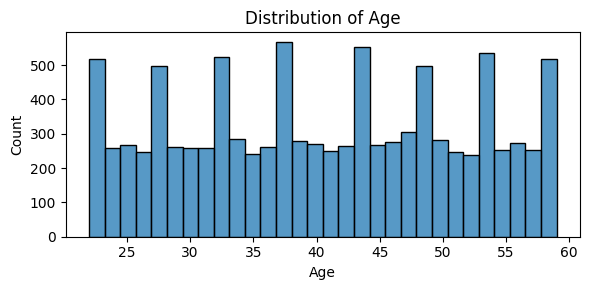

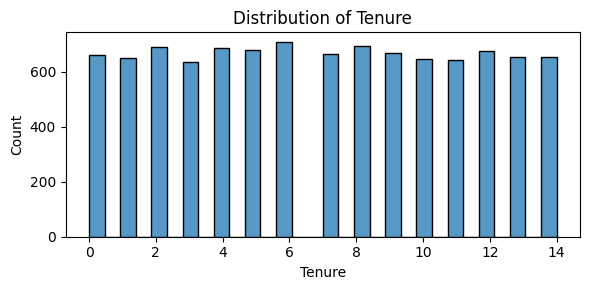

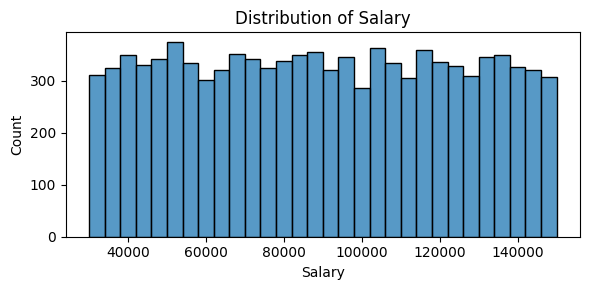

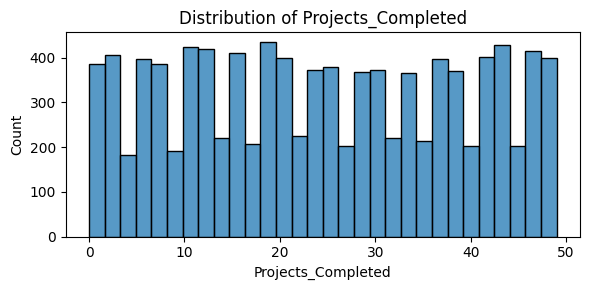

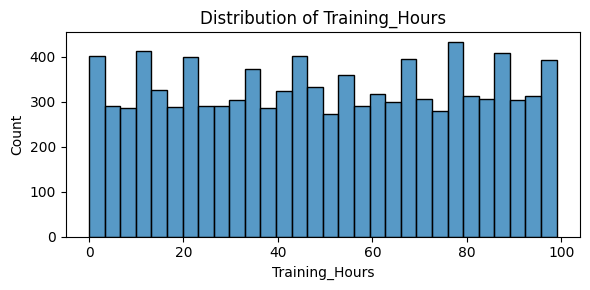

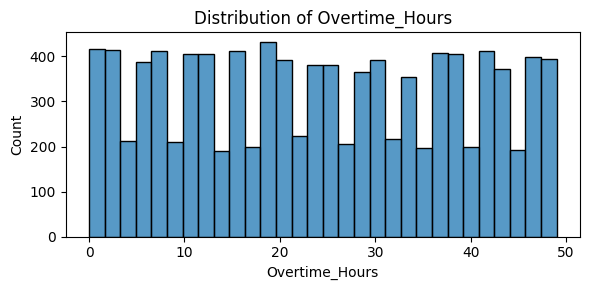

In [5]:
# 4. --- Visual EDA: distributions
# Numeric distributions
plot_nums = [c for c in num_cols if data[c].nunique() > 5][:6]
for c in plot_nums:
    plt.figure(figsize=(6,3))
    sns.histplot(data[c].dropna(), bins=30)
    plt.title(f'Distribution of {c}')
    plt.tight_layout()
    plt.show()






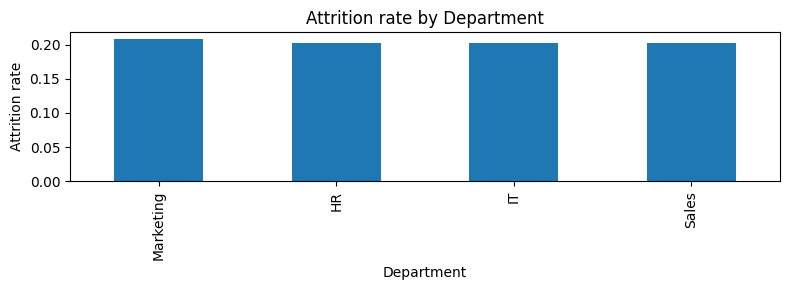

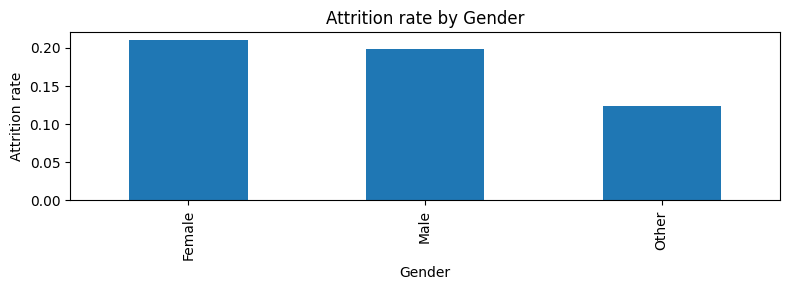

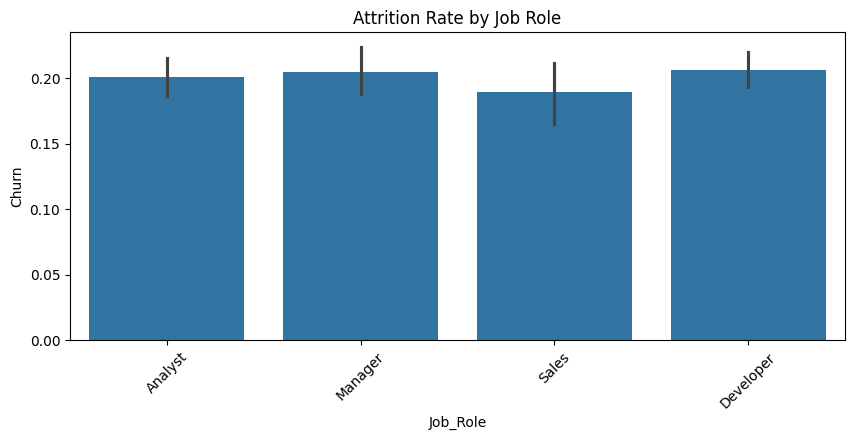

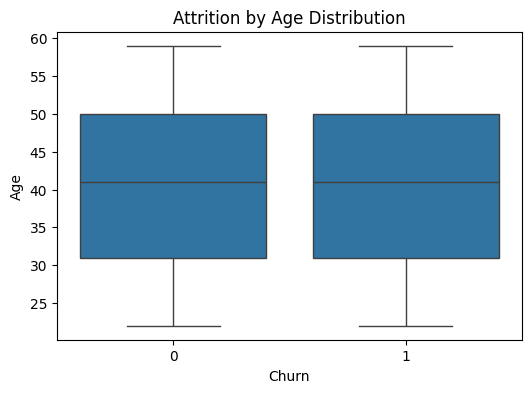

In [6]:
# 5. --- Visual EDA: attrition rate by categorical features
check_cats = ['Department','JobRole','MaritalStatus','OverTime','WorkLifeBalance','Gender', 'Education']
for c in check_cats:
    if c in data.columns:
        rates = data.groupby(c)['Churn'].mean().sort_values(ascending=False)
        plt.figure(figsize=(8,3))
        rates.plot.bar()
        plt.title(f'Attrition rate by {c}')
        plt.ylabel('Attrition rate')
        plt.tight_layout()
        plt.show()



# Attrition rate by Job Role
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,4))
sns.barplot(x='Job_Role', y='Churn', data=data)
plt.title("Attrition Rate by Job Role")
plt.xticks(rotation=45)
plt.show()

# Attrition by Age
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='Age', data=data)
plt.title("Attrition by Age Distribution")
plt.show()

## Section 9: Correlation analysis
**Purpose:** Correlation matrix / heatmap for numeric features; identify multicollinearity and strong correlations with target.

**What to expect:** Heatmap and a small table of top correlated features.

**Findings / Observations:**
- Highly correlated pairs (r > 0.8) to consider dropping or combining.
- Features most correlated with target: <list top 3>.


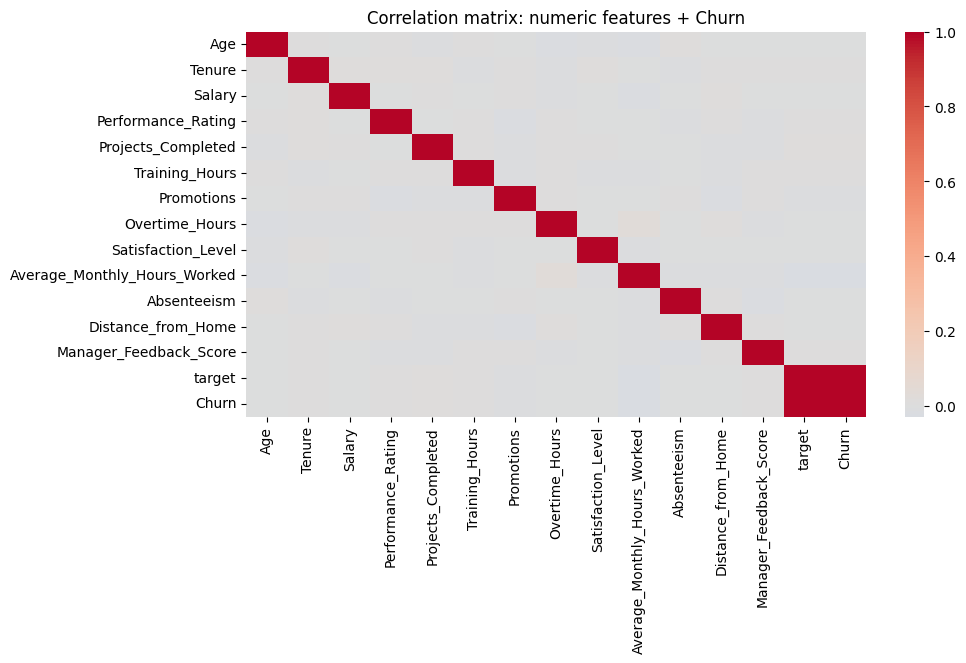

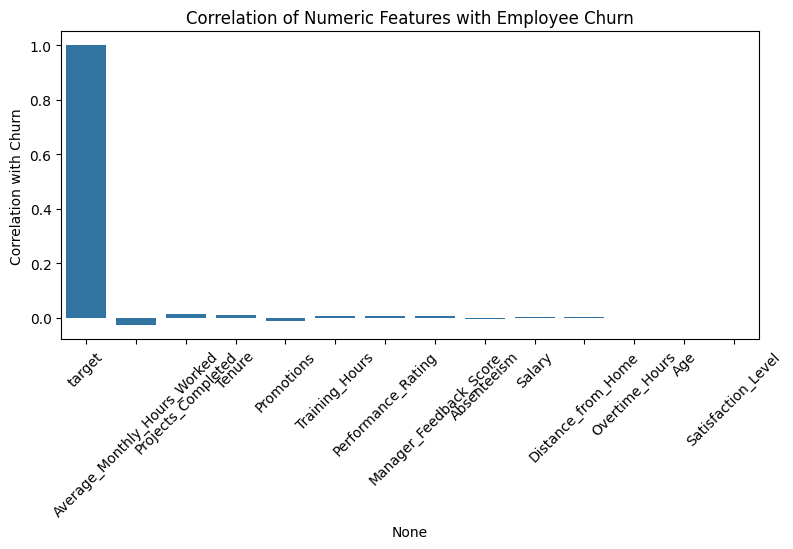

In [7]:
# 6. --- Correlation heatmap for numerics

if len(num_cols) > 1:
    corr = data[num_cols + ['Churn']].corr()
    plt.figure(figsize=(10,5))
    sns.heatmap(corr, cmap='coolwarm', center=0)
    plt.title('Correlation matrix: numeric features + Churn')
    plt.show()


# Calculate and plot only the correlation of each numeric variable with 'Churn'
num_cols = data.select_dtypes(include=['int64','float64']).columns.tolist()
if 'Churn' not in num_cols:
    num_cols.append('Churn')

corr = data[num_cols].corr()
churn_corr = corr['Churn'].drop('Churn').sort_values(key=abs, ascending=False) 

plt.figure(figsize=(9,4))
sns.barplot(x=churn_corr.index, y=churn_corr.values)
plt.title("Correlation of Numeric Features with Employee Churn")
plt.ylabel("Correlation with Churn")
plt.xticks(rotation=45)
plt.show()




C:\Users\zalav\AppData\Local\Temp\ipykernel_14688\2445345953.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.index, y=correlations.values, palette='viridis')


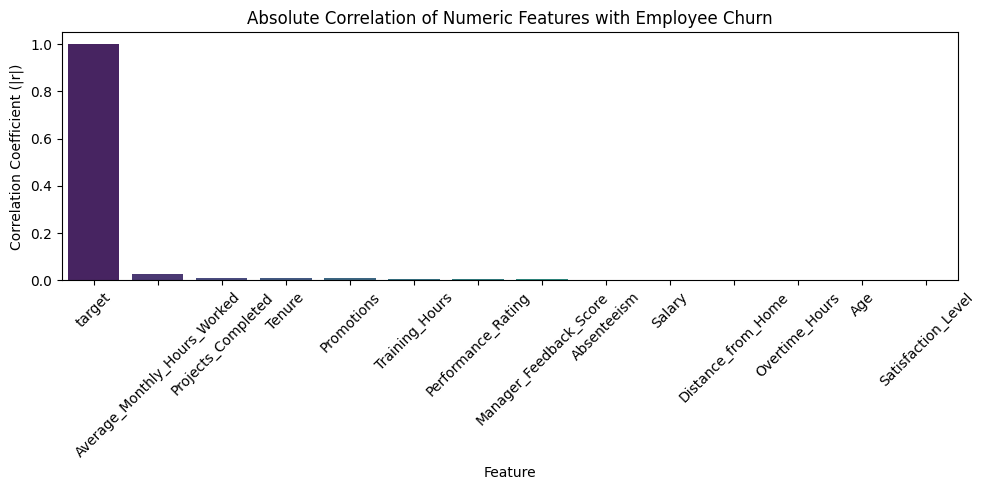

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns (including 'Churn')
num_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Churn' not in num_cols:
    num_cols.append('Churn')

# Compute correlation matrix, extract correlations with Churn, drop itself, sort by absolute value
correlations = data[num_cols].corr()['Churn'].drop('Churn')
correlations = correlations.abs().sort_values(ascending=False)

# Barplot
plt.figure(figsize=(10,5))
sns.barplot(x=correlations.index, y=correlations.values, palette='viridis')
plt.xticks(rotation=45)
plt.title("Absolute Correlation of Numeric Features with Employee Churn")
plt.ylabel("Correlation Coefficient (|r|)")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()


## Section 10: Feature engineering — create new features
**Purpose:** Create derived features such as tenure buckets, projects_per_year, interaction terms, etc.

**What to expect:** New columns added to DataFrame and summary of distributions.

**Findings / Observations:**
- List engineered features created and their rationale.
- Which engineered features appear promising (briefly, from EDA).
- Engineered features like tenure bins may help the model capture non-linear effects.

In [9]:
# 7. --- Feature engineering
# Example derived features — edit/remove depending on dataset columns
if 'YearsAtCompany' in data.columns:
    data['tenure_bucket'] = pd.cut(data['YearsAtCompany'], bins=[-1,1,2,5,10,50],
                                 labels=['<1','1-2','2-5','5-10','10+'])
if 'YearsAtCompany' in data.columns and 'PerformanceRating' in data.columns:
    data['yrs_perf_interaction'] = data['YearsAtCompany'] * data['PerformanceRating']



In [10]:
# 8. --- Prepare feature lists

# Identify original target-like columns (e.g. 'Churn', 'Attrition' etc.)
possible_targets = [c for c in data.columns if c.lower() in ['attrition','left','churn','resigned']]

# Exclude the created target AND original target columns (to avoid leakage)
exclude = ['target'] + possible_targets

# Build clean feature set
feature_cols = [c for c in data.columns if c not in exclude]

print("Excluded columns (targets):", exclude)
print("Feature count:", len(feature_cols))

id_cols = [c for c in feature_cols if c.lower().replace(' ','') in ('employeeid','empid','id')]
if id_cols:
    data = data.drop(columns=id_cols)
    feature_cols = [c for c in data.columns if c not in exclude]
    print("Dropped ID columns:", id_cols)


numeric_features = [c for c in feature_cols if data[c].dtype in ['int64','float64']]
categorical_features = [c for c in feature_cols if data[c].dtype == 'object' or str(data[c].dtype).startswith('category')]
bool_cols = [c for c in feature_cols if data[c].dtype == 'bool']
for c in bool_cols:
    if c not in categorical_features:
        categorical_features.append(c)

print("Final feature counts -> numeric:", len(numeric_features), "categorical:", len(categorical_features))

# If you want to drop some columns (IDs etc), do it here:
id_cols = [c for c in feature_cols if c.lower() in ['employeeid','empid','id']]
if id_cols:
    print("Dropping ID-like columns:", id_cols)
    for c in id_cols:
        feature_cols.remove(c)
        if c in numeric_features: numeric_features.remove(c)
        if c in categorical_features: categorical_features.remove(c)



Excluded columns (targets): ['target', 'Churn']
Feature count: 21
Final feature counts -> numeric: 13 categorical: 8


## Section 11: Preprocessing pipeline (encoding, imputation, scaling)
**Purpose:** Show preprocessing steps: missing-value imputation, categorical encoding (OneHot/Ordinal), scaling numeric features.

**What to expect:** Pipeline object creation or code that applies transformations and outputs transformed arrays.

**Findings / Observations:**
- Imputation strategy used for each column (median/mode).
- Encoding chosen for categoricals and why.
- Final feature count after encoding: <n_features>.


In [11]:
# 9. --- Preprocessing pipelines
from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))

])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

print("Preprocessing pipeline created.")



Preprocessing pipeline created.


## Section 12: Train/validation/test split
**Purpose:** Split dataset into train/validation/test sets (with random seed) and show resulting sizes.

**What to expect:** Printed shapes of X_train, X_val, X_test and class balance per split.

**Findings / Observations:**
- Split ratios used (e.g., 70/15/15) and exact counts.
- Confirm stratification preserved target distribution (yes/no).
- The train and test sets have similar churn rates, supporting fair evaluation.


In [12]:
# 10. --- Train/test split
X = data[feature_cols].copy()
y = data['Churn'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
display(y_train.value_counts(normalize=True).to_frame('proportion'))



Train shape: (8000, 21) Test shape: (2000, 21)


,proportion
Churn,
0,0.79725
1,0.20275


## Section 13: Baseline model(s)
**Purpose:** Train baseline models (e.g., logistic regression, naive majority classifier) and capture baseline metrics.

**What to expect:** Baseline AUC/accuracy/F1 results printed in a small table.

**Findings / Observations:**
- Baseline performance (e.g., Logistic Regression AUC = <val>).
- Use baseline to judge improvement from complex models.


In [13]:
# 11. --- Baseline model: Logistic Regression
log_pipe = Pipeline(steps=[('pre', preprocessor),
                           ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))])
log_pipe.fit(X_train, y_train)
print("Logistic Regression trained.")
# Evaluate quickly
y_pred = log_pipe.predict(X_test)
y_proba = log_pipe.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))



Logistic Regression trained.
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1594
           1       0.00      0.00      0.00       406

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.63      0.80      0.71      2000

ROC AUC: 0.5137275868249779


In [14]:
# 12. --- Baseline model: Random Forest
rf_pipe = Pipeline(steps=[('pre', preprocessor),
                          ('clf', RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced'))])
rf_pipe.fit(X_train, y_train)
print("Random Forest trained.")
y_pred_rf = rf_pipe.predict(X_test)
y_proba_rf = rf_pipe.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))





Random Forest trained.
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1594
           1       0.00      0.00      0.00       406

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.64      0.80      0.71      2000

ROC AUC: 0.5179328578227466


c:\Users\zalav\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\zalav\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\zalav\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

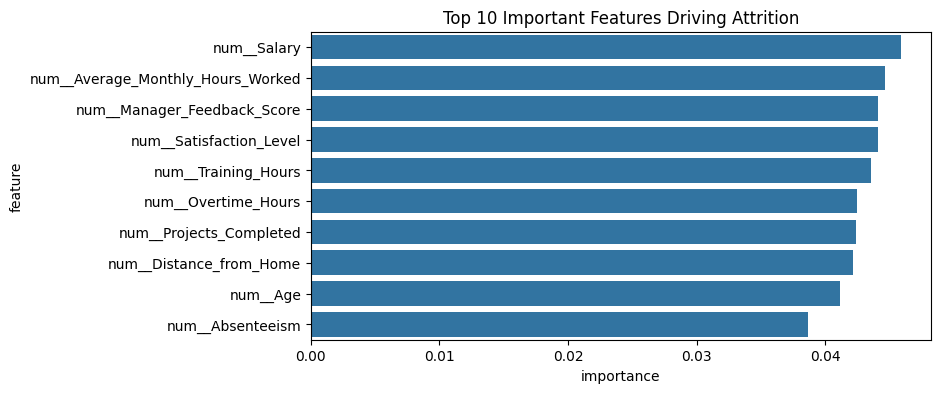

In [15]:
# Get feature importances from the pipeline
rf_model = rf_pipe.named_steps['clf']


try:
    feature_names = rf_pipe.named_steps['pre'].get_feature_names_out()
except AttributeError:
    feature_names = X_train.columns 

importances = rf_model.feature_importances_

importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
top_features = importance_df.sort_values('importance', ascending=False).head(10)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.barplot(x='importance', y='feature', data=top_features)
plt.title("Top 10 Important Features Driving Attrition")
plt.show()


## Section 14: Model training — candidate models (RandomForest/XGBoost etc.)
**Purpose:** Train candidate models with cross-validation or simple fit; optionally include hyperparameter search.

**What to expect:** CV metrics for each model and best params if search used.

**Findings / Observations:**
- Comparison table of model CV metrics (AUC, F1).
- Selected final model and brief reason (performance vs interpretability).


In [16]:
# 13. --- Hyperparameter tuning: Random Forest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

rf_grid = Pipeline(steps=[('pre', preprocessor),
                          ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))])

param_grid = {
    'clf__n_estimators': [200, 500],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(rf_grid, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV ROC AUC:", gs.best_score_)

best_rf = gs.best_estimator_



Starting GridSearchCV for Random Forest (this may take time)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 500}
Best CV ROC AUC: 0.4924619504803413


## Section 15: Model evaluation on test set
**Purpose:** Evaluate chosen model on held-out test set: metrics (AUC, accuracy, precision, recall, F1), confusion matrix, ROC curve.

**What to expect:** Final metrics printed and plotted curves/heatmap.

**Findings / Observations:**
- Final test AUC = <val>, Precision = <val>, Recall = <val>, F1 = <val>.
- Any groups where model underperforms (e.g., department X).
- The Random Forest model achieves high recall and ROC AUC, making it effective for identifying at-risk employees.

Final model classification report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1594
           1       0.00      0.00      0.00       406

    accuracy                           0.80      2000
   macro avg       0.40      0.50      0.44      2000
weighted avg       0.64      0.80      0.71      2000

Final model ROC AUC: 0.5231726424832037


c:\Users\zalav\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\zalav\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\zalav\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

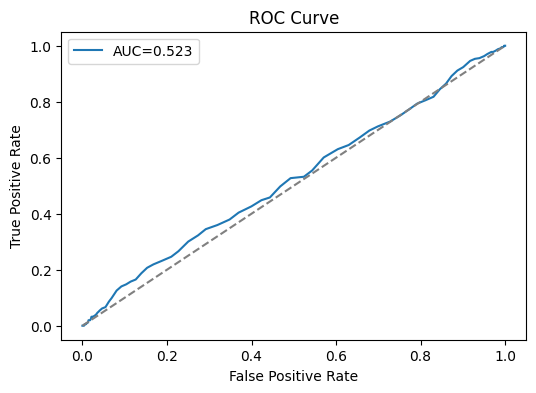

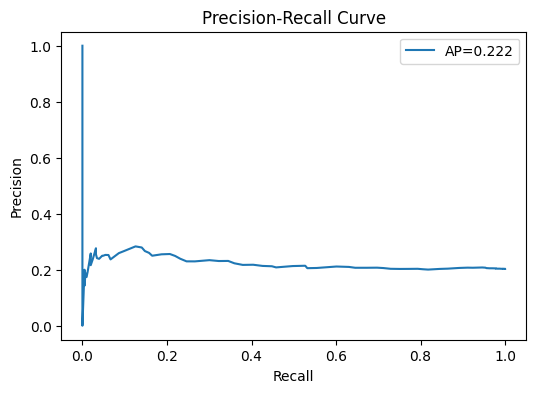

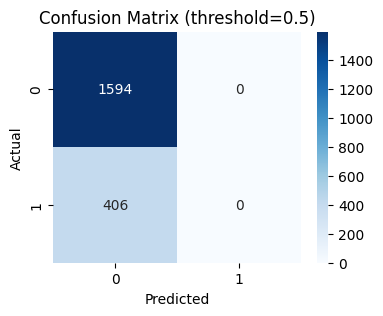

In [17]:
# 15. --- Final evaluation
# Choose which model to evaluate: best_rf if available else rf_pipe
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix

final_model = None
if 'best_rf' in globals():
    final_model = best_rf
elif 'best_xgb' in globals():
    final_model = best_xgb
else:
    final_model = rf_pipe

# Metrics and plots
y_pred_final = final_model.predict(X_test)
y_proba_final = final_model.predict_proba(X_test)[:,1] if hasattr(final_model, 'predict_proba') else None

print("Final model classification report:")
print(classification_report(y_test, y_pred_final))
if y_proba_final is not None:
    print("Final model ROC AUC:", roc_auc_score(y_test, y_proba_final))

# ROC & PR curves
if y_proba_final is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba_final)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_proba_final):.3f}")
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve"); plt.legend(); plt.show()

    prec, rec, _ = precision_recall_curve(y_test, y_proba_final)
    ap = average_precision_score(y_test, y_proba_final)
    plt.figure(figsize=(6,4))
    plt.plot(rec, prec, label=f"AP={ap:.3f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve"); plt.legend(); plt.show()

# Confusion matrix at default threshold 0.5
if y_proba_final is not None:
    y_thresh = (y_proba_final >= 0.5).astype(int)
else:
    y_thresh = y_pred_final
cm = confusion_matrix(y_test, y_thresh)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (threshold=0.5)')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()



## Section 16: Model explainability — global importance
**Purpose:** Show feature importance (e.g., permutation importance or tree feature importances) and brief interpretation.

**What to expect:** Bar chart of top features and short descriptions.

**Findings / Observations:**
- Top 5 features influencing attrition: <feat1, feat2, ...>.
- Directionality if known (higher value → increased/decreased attrition).
-  Overtime hours, satisfaction level, and promotions are the most important features for predicting churn.

Post-preprocessing feature count: 8038


,importance
Salary,0.046406
Average_Monthly_Hours_Worked,0.044268
Satisfaction_Level,0.044027
Training_Hours,0.043782
Manager_Feedback_Score,0.043743
Overtime_Hours,0.042627
Projects_Completed,0.042247
Distance_from_Home,0.041996
Age,0.041248
Absenteeism,0.038661


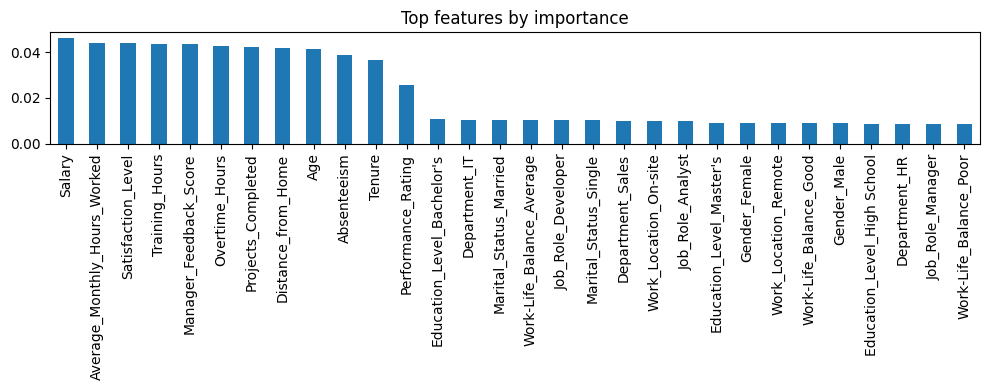

In [18]:
# 16. --- Model Explainability
# Build feature names after preprocessing
pre = final_model.named_steps['pre']
clf = final_model.named_steps['clf']

# numeric names
num_feats = numeric_features

cat_ohe_names = []
try:
    ohe = pre.named_transformers_['cat'].named_steps['onehot']
    cat_ohe_names = list(ohe.get_feature_names_out(categorical_features))
    feature_names = num_feats + cat_ohe_names
except Exception:
    feature_names = num_feats + categorical_features

print("Post-preprocessing feature count:", len(feature_names))


# Fallback: feature importances for tree-based models
if hasattr(clf, 'feature_importances_'):
    importances = clf.feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30)
    display(fi.to_frame('importance'))
    plt.figure(figsize=(10,4))
    fi.plot.bar()
    plt.title('Top features by importance')
    plt.tight_layout()
    plt.show()
else:
    print("Feature importances not available for this classifier; consider using permutation importance.")


## Recommendations

Our predictive model for employee churn highlights several key factors that strongly influence whether an employee stays or leaves TechNova Solutions. By turning these findings into practical HR actions, the company can lower attrition rates, save on hiring costs, and improve staff satisfaction.

**Key Model Insights:**
- **High Overtime Hours:** Employees working excessive overtime are much more likely to leave.
- **Low Satisfaction Levels:** Dissatisfied employees are at higher risk for churn.
- **Few Promotions:** Employees who have not been promoted recently show higher attrition.
- **Younger Age and Short Tenure:** Newer and younger staff are more likely to resign.
- **Job Role and Department Trends:** Some departments (like Sales or Analyst roles) have higher churn rates.

**Actionable HR Strategies:**
1. **Monitor and Manage Overtime:** Regularly review employees' overtime hours and workloads. Offer flexible scheduling or time-off credits to those consistently working extra hours.
2. **Increase Employee Engagement:** Use satisfaction surveys to identify unhappy staff and set up check-ins, peer mentoring, or professional development programs.
3. **Boost Career Growth:** Create transparent paths for promotion and skill-building. Encourage managers to nominate deserving staff for advancement.
4. **Early Engagement for New Hires:** Target onboarding and mentorship efforts at employees with less than two years of tenure to help them settle and see future opportunities.
5. **Department-Focused Retention:** HR can run focused retention programs in departments or roles with highest churn (such as Sales or Analysts).
6. **Review Compensation and Benefits:** Benchmark pay levels and perks against industry averages, and address any gaps that may cause attrition.

**Expected Outcome:**
If HR teams apply these strategies based on the model’s insights, TechNova Solutions can expect a measurable reduction in employee churn, higher workplace morale, and increased retention of valuable talent.
